In [1]:
import random

import imageio
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from tqdm.notebook import tqdm

In [2]:
# Initialise the environment
env = gym.make("FrozenLake-v1", map_name="8x8", is_slippery=True, render_mode="rgb_array")

# Reset the environment to generate the first observation
observation, info = env.reset(seed=42)
for _ in range(100):
    # this is where you would insert your policy
    action = env.action_space.sample()

    # step (transition) through the environment with the action
    # receiving the next observation, reward and if the episode has terminated or truncated
    observation, reward, terminated, truncated, info = env.step(action)
    env.render()

    # If the episode has ended then we can reset to start a new episode
    if terminated or truncated:
        observation, info = env.reset()

env.close()

# Making Q-learning method

### init Q-table

In [3]:
state_space = env.observation_space.n
print("There are ", state_space, " possible states")

action_space = env.action_space.n
print("There are ", action_space, " possible actions")

def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

There are  64  possible states
There are  4  possible actions


In [4]:
Qtable_frozenlake = initialize_q_table(state_space, action_space)

### Create policies

<h5> Greedy policy

In [5]:
def greedy_policy(Qtable, state):
    return np.argmax(Qtable[state][:])

<h5> Esilon greedy policy

In [6]:
def espilon_greedy_policy(Qtable, state, epsilon):
    # Randomly generate a number between 0 and 1
    random_num = np.random.binomial(1, 0.2)
    # if random_num > greater than epsilon --> exploitation
    if random_num > epsilon:
        # Take the action with the highest value given a state
        # np.argmax can be useful here
        action = greedy_policy(Qtable, state)
        # else --> exploration
    else:
        action = env.action_space.sample()
    return action

### Q-learning algorithm

In [7]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  episode_rewards = []
  for episode in tqdm(range(n_training_episodes)):
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state, info = env.reset()
    step = 0
    terminated = False
    truncated = False
    sum_reward = 0
    gamma_p = 1.0

    # repeat
    for step in range(max_steps):
      # Choose the action At using epsilon greedy policy
      # action = epsilon_greedy_policy(Qtable, state, epsilon=epsilon)
      # action = softmax_policy(Qtable, state)
      action = espilon_greedy_policy(Qtable, state, epsilon)

      # Take action At and observe Rt+1 and St+1
      # Take the action (a) and observe the outcome state(s') and reward (r)
      new_state, reward, terminated, truncated, info = env.step(action)

      # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])

      sum_reward += gamma_p * reward
      gamma_p *= gamma

      # If terminated or truncated finish the episode
      if terminated or truncated:
        break

      # Our next state is the new state
      state = new_state
    episode_rewards.append(sum_reward)
  return Qtable, episode_rewards

#### Learning 

<h5> Learning parameters

In [8]:
# Training parameters
n_training_episodes = 30000  # Total training episodes
learning_rate = 0.7          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
env_id = "FrozenLake-v1"     # Name of the environment
max_steps = 99               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.0005            # Exponential decay rate for exploration prob

In [9]:
Qtable_frozenlake, reward_stats = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [11]:
np.max(Qtable_frozenlake, axis=1)

array([0.2964792 , 0.32817192, 0.34879552, 0.37355982, 0.38968992,
       0.44134669, 0.47100696, 0.47254486, 0.28259344, 0.30202501,
       0.32084381, 0.37213577, 0.38014903, 0.42877339, 0.5138818 ,
       0.50090922, 0.2624515 , 0.23947544, 0.23537439, 0.        ,
       0.41460217, 0.49045405, 0.51458087, 0.49986646, 0.23131663,
       0.22628025, 0.25264149, 0.22525218, 0.29657102, 0.        ,
       0.50958584, 0.61513684, 0.20367537, 0.19943597, 0.16858667,
       0.        , 0.31417753, 0.35358065, 0.47663792, 0.69680149,
       0.19378186, 0.        , 0.        , 0.07072301, 0.27766868,
       0.33861275, 0.        , 0.71321901, 0.12772743, 0.        ,
       0.01041922, 0.17208541, 0.        , 0.57907875, 0.        ,
       0.95972994, 0.14402331, 0.07386005, 0.03951982, 0.        ,
       0.58366125, 0.62428617, 0.60931894, 0.        ])

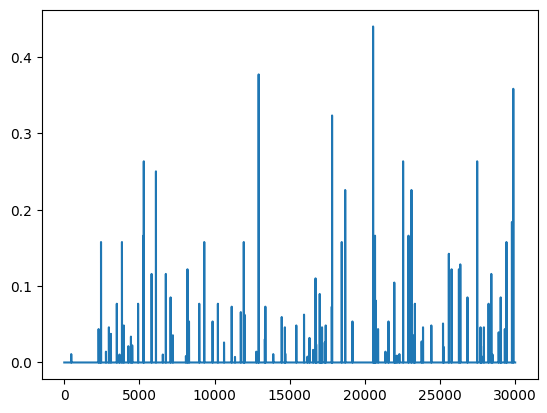

In [12]:
import matplotlib.pyplot as plt
plt.plot(reward_stats)

In [13]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param max_steps: Maximum number of steps per episode
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param Q: The Q-table
  :param seed: The evaluation seed array (for taxi-v3)
  """
  episode_rewards = []
  for episode in tqdm(range(n_eval_episodes)):
    if seed:
      state, info = env.reset(seed=seed[episode])
    else:
      state, info = env.reset()
    step = 0
    truncated = False
    terminated = False
    total_rewards_ep = 0

    for step in range(max_steps):
      # Take the action (index) that have the maximum expected future reward given that state
      action = greedy_policy(Q, state)
      new_state, reward, terminated, truncated, info = env.step(action)
      total_rewards_ep += reward

      if terminated or truncated:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [14]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]

Mean_reward=0.04 +/- 0.20


In [15]:
def record_video(env, Qtable, out_directory, fps=1):
  """
  Generate a replay video of the agent
  :param env
  :param Qtable: Qtable of our agent
  :param out_directory
  :param fps: how many frame per seconds (with taxi-v3 and frozenlake-v1 we use 1)
  """
  images = []
  terminated = False
  truncated = False
  state, info = env.reset(seed=random.randint(0,500))
  img = env.render()
  images.append(img)
  while not terminated or truncated:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state][:])
    state, reward, terminated, truncated, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render()
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], fps=fps)

In [17]:
record_video(env, Qtable_frozenlake, 'record.mp4')